In [24]:
import pandas as pd
import seaborn as sns
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt
from descriptors.preprocessing import preprocess

In [25]:
# Faire les diagrammes croises par count
nicolit= pd.read_csv("data/NiCOlit.csv")
nicolit= preprocess(nicolit)

Classification des ligands

In [26]:
ligand_cat = ['Phos' ,'DiPhos', 'NHC', 'others']
lig_cat = []
for smi in nicolit.effective_ligand:
    if 'P' in smi:
        if smi.count('P') == 1:
            lig_cat.append('Phos')
        else:
            lig_cat.append('DiPhos')
    elif '[C]' in smi:
        lig_cat.append('NHC')
    else:
        lig_cat.append('others')
        
nicolit['ligand_cat'] = lig_cat

Substrate classification:

In [27]:
mols = [Chem.MolFromSmiles(smi) for smi in nicolit.substrate]
sub_class = []
for mol in mols:
    if mol.HasSubstructMatch(Chem.MolFromSmiles('c1ncncn1')) or mol.HasSubstructMatch(Chem.MolFromSmiles('C1=NC=NC=N1')):
        sub_class.append('Otriazine')
    elif mol.HasSubstructMatch(Chem.MolFromSmiles('OC(=O)C(C)(C)C')):
        sub_class.append('OPiv')
    elif mol.HasSubstructMatch(Chem.MolFromSmiles('OC(=O)N')):
        sub_class.append('OC(=O)N')
    elif mol.HasSubstructMatch(Chem.MolFromSmiles('OC(=O)O')):
        sub_class.append('OC(=O)O')
    elif mol.HasSubstructMatch(Chem.MolFromSmiles('O[Si](C)(C)C')) or mol.HasSubstructMatch(Chem.MolFromSmarts('o[Si](C)(C)C')):
        sub_class.append('OSi(C)(C)C')
    else:
        mol = Chem.AddHs(mol)
        if mol.HasSubstructMatch(Chem.MolFromSmiles('OC(=O)C([H])([H])[H]')):
            sub_class.append('OAc')
        elif mol.HasSubstructMatch(Chem.MolFromSmiles('c1ccccc1Oc1ccccc1')):
            sub_class.append('OPh')
        elif mol.HasSubstructMatch(Chem.MolFromSmiles('OCOC')):
            sub_class.append('OCOC')
        elif mol.HasSubstructMatch(Chem.MolFromSmiles('OC([H])([H])[H]')):
            sub_class.append('OCH3')
        else:
            sub_class.append('others')           
sub_classes = np.unique(sub_class)

nicolit['substrate_cat'] = sub_class

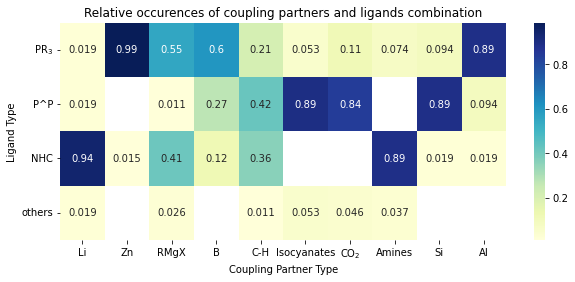

In [44]:
# Plot 1: Ligand-Coupling Partner
cc = nicolit.coupling_partner_class.unique()
m = np.zeros((len(ligand_cat), len(cc)))
mask = np.ones_like(m)
for i in range(np.shape(m)[0]):
    nicolit_lig = nicolit[nicolit['ligand_cat'] == ligand_cat[i]]
    for j in range(np.shape(m)[1]):
        num_cc = len(nicolit[nicolit['coupling_partner_class']==cc[j]])
        m[i][j] = len(nicolit_lig[nicolit_lig['coupling_partner_class']==cc[j]])/num_cc
        if m[i][j] != 0:
            mask[i][j] = 0

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(111)
sns.heatmap(m, ax=ax, annot=True, cmap="YlGnBu", mask=mask)
ax.set_xticklabels(cc)
ax.set_yticklabels(['PR$_3$', 'P^P', 'NHC', 'others'])
ax.set_xticklabels(['Li', 'Zn', 'RMgX', 'B', 'C-H', 'Isocyanates',
                   'CO$_2$', 'Amines', 'Si', 'Al'])
ax.set_ylabel("Ligand Type")
ax.set_xlabel("Coupling Partner Type")
ax.tick_params(axis='y', rotation=0)
plt.title("Relative occurences of coupling partners and ligands combination")

fig.savefig("cc_lig.png", dpi=300, bbox_inches="tight")
plt.show()

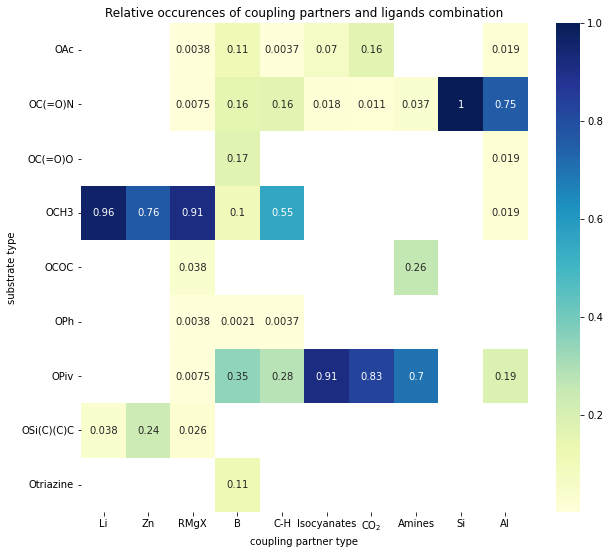

In [45]:
# Plot 2: Ligand-Coupling Partner
m_2 = np.zeros((len(sub_classes), len(cc)))
mask_2 = np.ones((len(sub_classes), len(cc)))
for i in range(np.shape(m_2)[0]):
    nicolit_sub = nicolit[nicolit['substrate_cat'] == sub_classes[i]]
    for j in range(np.shape(m_2)[1]):
        num_cc = len(nicolit[nicolit['coupling_partner_class']==cc[j]])
        m_2[i][j] = len(nicolit_sub[nicolit_sub['coupling_partner_class']==cc[j]])/num_cc
        if m_2[i][j] != 0:
            mask_2[i][j] = 0
            
fig = plt.figure(figsize=(10,9))
ax = plt.subplot(111)

sns.heatmap(m_2, ax=ax, annot=True, cmap="YlGnBu", mask=mask_2)

ax.set_xticklabels(['Li', 'Zn', 'RMgX', 'B', 'C-H', 'Isocyanates',
                   'CO$_2$', 'Amines', 'Si', 'Al'])
ax.set_xlabel("coupling partner type")
ax.set_yticklabels(sub_classes)
ax.set_ylabel("substrate type")
ax.tick_params(axis='y', rotation=0)

fig.savefig("cc_sub.png", dpi=300, bbox_inches="tight")

plt.title("Relative occurences of coupling partners and ligands combination")
plt.show()

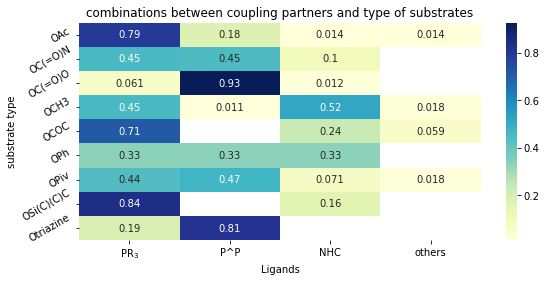

In [46]:
#Plot3 :
m_3 = np.zeros((len(ligand_cat), len(sub_classes)))
mask_3 = np.ones_like(m_3)
for i in range(np.shape(m_3)[0]):
    nicolit_sub = nicolit[nicolit['ligand_cat'] == ligand_cat[i]]
    for j in range(np.shape(m_3)[1]):
        num_cc = len(nicolit[nicolit['substrate_cat']==sub_classes[j]])
        m_3[i][j] = len(nicolit_sub[nicolit_sub['substrate_cat']==sub_classes[j]])/num_cc
        if m_3[i][j] != 0:
            mask_3[i][j] = 0

fig = plt.figure(figsize=(9,4))
ax = plt.subplot(111)

sns.heatmap(np.transpose(m_3), ax=ax, annot=True, cmap="YlGnBu", mask=np.transpose(mask_3))
ax.set_xlabel("Ligands")
ax.set_xticklabels(['PR$_3$', 'P^P', 'NHC', 'others'])
ax.set_yticklabels(sub_classes)
ax.set_ylabel("substrate type")
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='y', rotation=30)
plt.title("combinations between coupling partners and type of substrates")
plt.show()

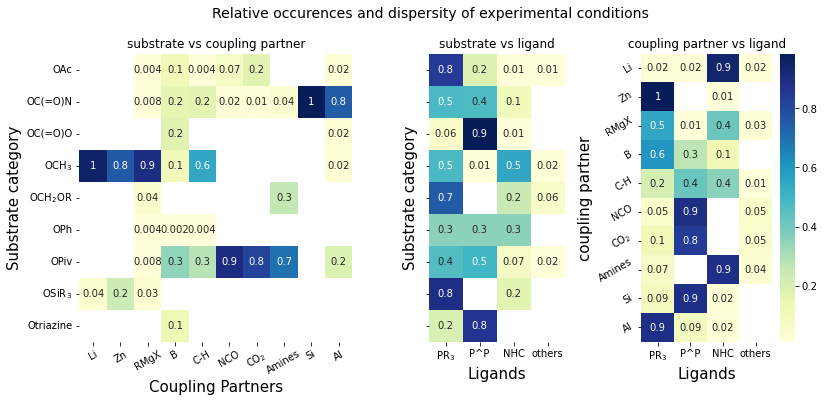

In [103]:
# Large plot :

fig, ax = plt.subplots(figsize=(13, 5), nrows=1, ncols=3, gridspec_kw={'width_ratios': [2, 1, 1.2]})

cp_labels = ['Li', 'Zn', 'RMgX', 'B', 'C-H', 'NCO',
                   'CO$_2$', 'Amines', 'Si', 'Al']
sub_labels = ['OAc', 'OC(=O)N', 'OC(=O)O', 'OCH$_3$', 'OCH$_2$OR', 'OPh',
                   'OPiv', 'OSiR$_3$', 'Otriazine']

# sub-cp
sns.heatmap(m_2, ax=ax[0], annot=True, cmap="YlGnBu", mask=mask_2,
           cbar=False, fmt='.1g')
ax[0].set_yticklabels(sub_labels)
ax[0].set_ylabel("Substrate category", fontsize=15)
ax[0].set_xticklabels(cp_labels)
ax[0].set_xlabel("Coupling Partners", fontsize=15)
ax[0].tick_params(axis='y', rotation=0)
ax[0].tick_params(axis='x', rotation=30)
ax[0].set_title("substrate vs coupling partner")

# sub-cp
sns.heatmap(np.transpose(m_3), ax=ax[1], annot=True, cmap="YlGnBu", 
            mask=np.transpose(mask_3),
            cbar=False, fmt='.1g')
ax[1].set_xticklabels(['PR$_3$', 'P^P', 'NHC', 'others'])
ax[1].set_xlabel("Ligands", fontsize=15)
ax[1].set_yticklabels([])
ax[1].set_title("substrate vs ligand")
ax[1].set_ylabel("Substrate category", fontsize=15)


# sub-lig
sns.heatmap(np.transpose(m)  , ax=ax[2], 
            annot=True, cmap="YlGnBu", mask=np.transpose(mask),
           fmt='.1g')
ax[2].set_xlabel("Ligands", fontsize=15)
ax[2].set_xticklabels(['PR$_3$', 'P^P', 'NHC', 'others'])
ax[2].set_yticklabels(['Li', 'Zn', 'RMgX', 'B', 'C-H', 'NCO',
                   'CO$_2$', 'Amines', 'Si', 'Al'])
ax[2].tick_params(axis='y', rotation=30)
ax[2].set_title("coupling partner vs ligand")
ax[2].set_ylabel("coupling partner", fontsize=15)

fig.subplots_adjust(wspace=0.4, hspace=0.2, top=0.85, bottom=0.05)
plt.suptitle("Relative occurences and dispersity of experimental conditions", fontsize=14)

fig.savefig("occurences.png", dpi=300, bbox_inches="tight")